In [34]:
import matplotlib
import pickle
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
from matplotlib import rc, font_manager
style.use("fivethirtyeight")
style.use("seaborn-talk")
plt.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.unicode_minus'] =False

%matplotlib inline

# 1. 데이터 불러오기

## 1.1 wiki 데이터 불러오기

In [6]:
with open(os.path.join("../input/data/wikipedia_documents.json"), "r", encoding="utf-8") as f:
    wiki = json.load(f)
wiki['0'].keys()

dict_keys(['text', 'corpus_source', 'url', 'domain', 'title', 'author', 'html', 'document_id'])

In [7]:
wiki = pd.DataFrame(wiki).T
wiki.head()

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [8]:
len(wiki)

60613

## 1.2 train/valid 데이터 불러오기

In [9]:
# train_dataset을 불러오고 싶은 경우
from datasets import load_from_disk
train_dataset = load_from_disk("../input/data/train_dataset/")

In [10]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

- id: 질문의 고유 id
- question: 질문
- answers: 답변에 대한 정보. 하나의 질문에 하나의 답변만 존재함
    - answer_start : 답변의 시작 위치
    - text: 답변의 텍스트
- context: 답변이 포함된 문서
- title: 문서의 제목
- document_id: 문서의 고유 id

In [11]:
train=pd.DataFrame({'title':train_dataset['train']['title'], 'context':train_dataset['train']['context'], 'question':train_dataset['train']['question'], 'id':train_dataset['train']['id'], 'answers':train_dataset['train']['answers'], 'document_id':train_dataset['train']['document_id'], '__index_level_0__':train_dataset['train']['__index_level_0__']})
valid=pd.DataFrame({'title':train_dataset['validation']['title'], 'context':train_dataset['validation']['context'], 'question':train_dataset['validation']['question'], 'id':train_dataset['validation']['id'], 'answers':train_dataset['validation']['answers'], 'document_id':train_dataset['validation']['document_id'], '__index_level_0__':train_dataset['validation']['__index_level_0__']})

In [12]:
len(train)

3952

In [13]:
len(valid)

240

In [14]:
train.columns

Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__'],
      dtype='object')

In [15]:
valid.columns

Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__'],
      dtype='object')

In [16]:
train.head()

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548


## 1.3 중복 제거하기

In [60]:
train.shape, train.drop_duplicates(subset=['context', 'question']).shape

((3952, 7), (3952, 7))

In [61]:
valid.shape, valid.drop_duplicates(subset=['context', 'question']).shape

((240, 7), (240, 7))

In [62]:
wiki.shape, wiki.drop_duplicates().shape

((60613, 8), (60613, 8))

# 2. 토크나이징 후 길이 분포 확인하기

In [17]:
from transformers import AutoTokenizer

In [19]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
tokenizer

BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

## 2.0 wiki의 text 길이 분포 확인

In [48]:
def find_PAD(tokens):
    data = []

    for token in tokens:
        data.append(len(token))
    
    return data

In [49]:
wiki_tokens_len = find_PAD(tokenizer(wiki['text'].tolist())['input_ids'])

In [51]:
max(wiki_tokens_len), min(wiki_tokens_len)

(27541, 56)

Text(0.5, 0, 'wiki text len')

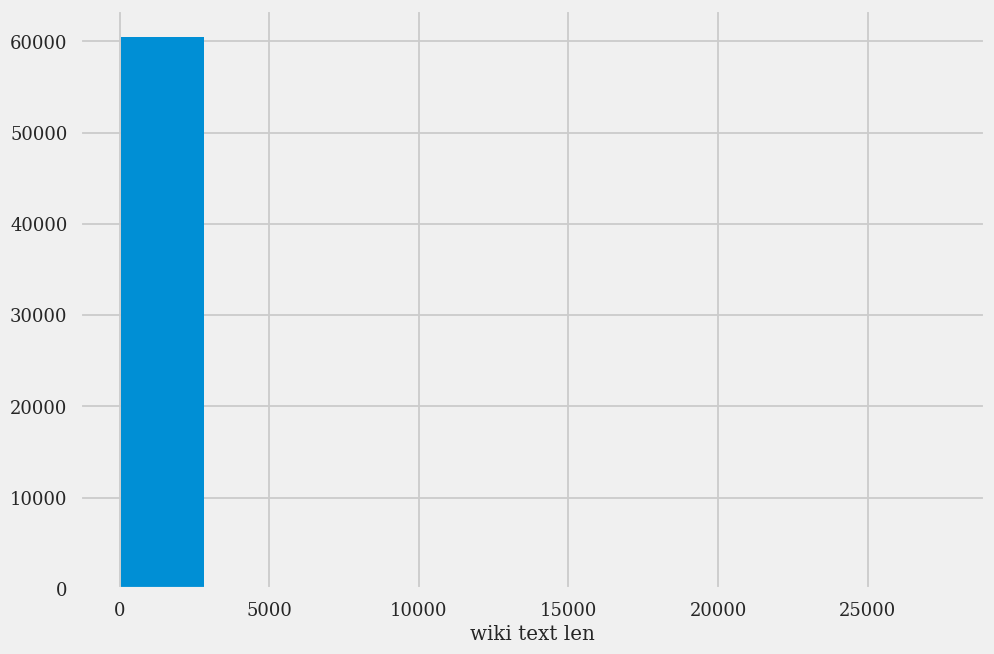

In [50]:
plt.hist(wiki_tokens_len)
plt.xlabel('wiki text len')

## 2.1 question에서 [PAD] 등장 위치 확인

In [26]:
train_q_tokens = tokenizer(train['question'].tolist())['input_ids']
val_q_tokens = tokenizer(valid['question'].tolist())['input_ids']

In [42]:
train_q_real_len = find_PAD(train_q_tokens)
val_q_real_len = find_PAD(val_q_tokens)

Text(0.5, 0, 'val question len')

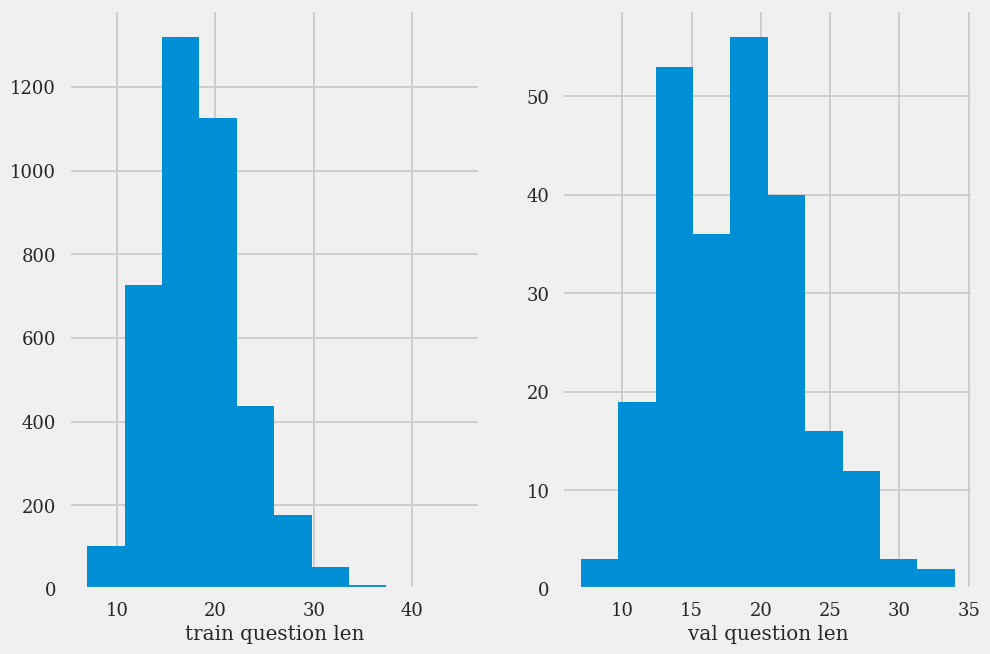

In [44]:
plt.subplot(1, 2, 1)
plt.hist(train_q_real_len)
plt.xlabel('train question len')

plt.subplot(1, 2, 2)
plt.hist(val_q_real_len)
plt.xlabel('val question len')

## 2.2 context에서 [PAD] 등장 위치 확인

In [45]:
train_c_tokens = tokenizer(train['context'].tolist())['input_ids']
val_c_tokens = tokenizer(valid['context'].tolist())['input_ids']

Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors


In [46]:
train_c_real_len = find_PAD(train_c_tokens)
val_c_real_len = find_PAD(val_c_tokens)

Text(0.5, 0, 'val context len')

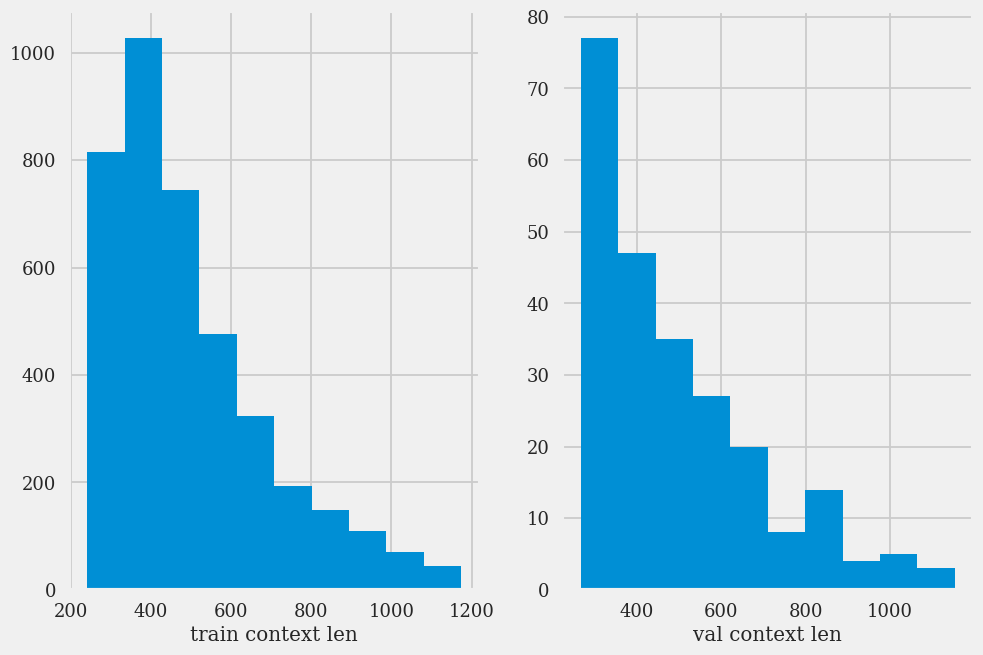

In [47]:
plt.subplot(1, 2, 1)
plt.hist(train_c_real_len)
plt.xlabel('train context len')

plt.subplot(1, 2, 2)
plt.hist(val_c_real_len)
plt.xlabel('val context len')

## 2.3 model input의 길이 분포 확인

In [52]:
def concat_tokens_len(p, c):
    data = []

    for p_len, c_len in zip(p, c):
        data.append(p_len + c_len)
    
    return data

In [53]:
train_tokens = concat_tokens_len(train_q_real_len, train_c_real_len)
val_tokens = concat_tokens_len(val_q_real_len, val_c_real_len)

Text(0.5, 0, 'val inputs len')

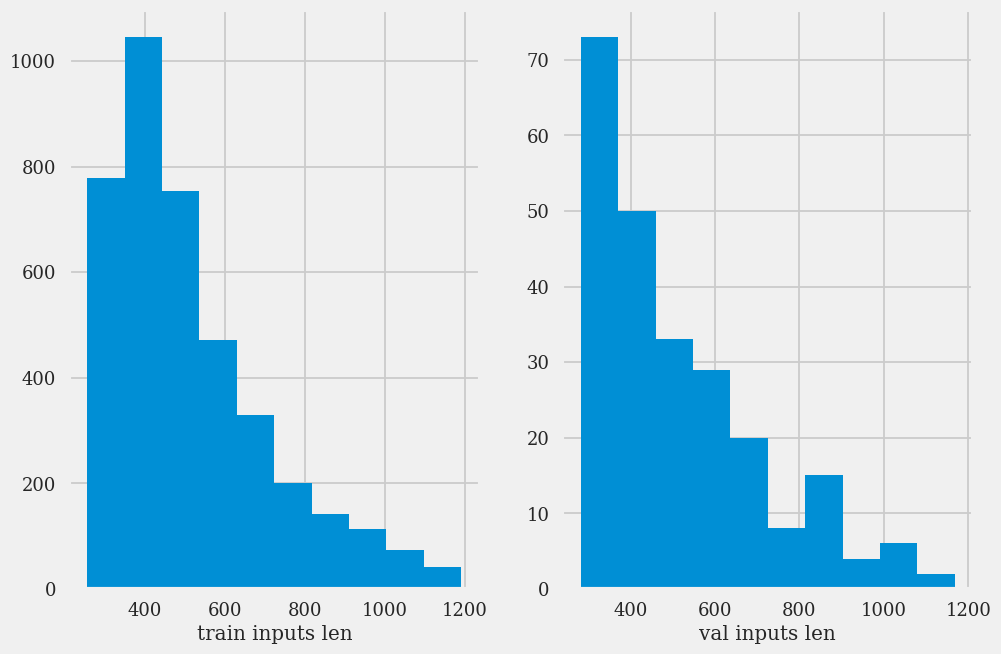

In [54]:
plt.subplot(1, 2, 1)
plt.hist(train_tokens)
plt.xlabel('train inputs len')

plt.subplot(1, 2, 2)
plt.hist(val_tokens)
plt.xlabel('val inputs len')

# 3. 텍스트 마이닝

## 3.0 wiki 마이닝

In [96]:
wiki['text'].str.replace('[\w\s.]', '', regex=True).unique()

array([',##(),,""""',
       ',*()*()*()*(),,,,*****:**:*,**:,,,,,,,,**:,**:,*,*,,,,*,()(),()(),*",",""",",,,,,*,,\'\'*"",\'\'',
       '()"",]],,,,‘’,,,""‘’()‘’,()()",,,,,"‘’,‘’",",,\'\'‘-’,,‘’,‘’,‘’‘’,‘’,‘’\'\'\'\'‘’,‘’,‘’=--,\'-\',,()‘’‘’‘’,‘’,‘’,‘’,‘’,‘’,‘’\'\',:-,‘’,,‘’,,,,,,,(),‘’‘’(),‘’()[]\'\',\',\'\'\'\'\'‘’,‘’,‘’,‘’,‘’,‘’,,‘’,‘’,‘’,‘’,,,,',
       ..., '·(,)(,),,,·,', ',(),()(),()()(),,(),(),,,·,·', ",()()''"],
      dtype=object)

In [101]:
wiki['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ]', '', regex=True).unique()

array(['', 'ㄸㅃ', 'ㅃㄸ', 'ㅇ', 'ㅡㄹ', 'ㄴ', 'ㅂㅍㅃㅂㅂㅂㅂㅍㅃ', 'ㅡ', 'ㄹㄴ',
       'ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅊㅋㅌㅍㅈㄱㄷㅂㅎㅑㅕㅛㅠ',
       'ㄱㄲㅏㅐㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎㅏㅐㅑㅒㅓㅔㅕㅖㅗㅘㅙㅚㅛㅜㅝㅞㅟㅠㅡㅢㅣㄱㄲㄳㄴㄵㄶㄷㄹㄺㄻㄼㄽㄾㄿㅀㅁㅂㅄㅅㅆㅇㅈㅊㅋㅌㅍㅎㅇㅇㄱㄴㄷㄹㅁㅂㅅㅈㅊㅋㅌㅍㅎㄲㄸㅃㅆㅉㅇㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅐㅒㅔㅖㅚㅟㅢㅘㅝㅙㅞㄱㄳㄴㄵㄶㄷㄹㄺㄻㄼㄽㄾㄿㅀㅁㅂㅄㅅㅇㅈㅊㅋㅌㅍㅎㄲㅆㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㄲㄸㅃㅆㅉㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅐㅒㅔㅖㅘㅚㅙㅝㅟㅞㅢㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㄲㄳㄵㄶㄺㄻㄼㄽㄾㄿㅀㅄㅆㅅㅇㅎㅣㅏ',
       'ㄱㅋㄷㅌㄴㅂㅍㅁㅈㅊㅅㅎㅇㄹㅡㅣㅗㅏㅜㅓㅛㅑㅠㅕㅖㅒㅋㄱㄷㅌㄱㄴㄷㄹㅁㅂㅅㅋㅌㅍㅈㅊㅇㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㄱㄴㄷㄹㅁㅂㅅㅈㅊㅌㅋㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㄱㄴㄷㄹㅁㅂㅅㅈㅊㅌㅋㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅌㅋㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ',
       'ㄱㄴㄷㄹㅁㅂㅅㅇㄱㄴㄷㄹㅁㅂㅅㅋㅌㅍㅈㅊㅇㅎ', 'ㅁㅂㅃㅍ', 'ㄷ', 'ㅅ', 'ㄹㅣㅑㅒㅕㅖㅛㅠㄹㄹㄴㅇㄹ', 'ㄱㅓㅓ',
       'ㅜㅗ', 'ㅇㅎㅇㅇㅇㅇㄹㅇㅇㅇㅇㅇㅇㅇㅇㅅㅇㅅㅇ', 'ㅈㅈㅈㄷㅈㅅㅈㅊㅅㅊㅈ',
       'ㅈㅊㅈㅊㅈㅊㅑㅒㅕㅖㅛㅠㅏㅐㅓㅔㅗㅜㅈㅊㅈㅊㅑㅒㅕㅖㅛㅠㅏㅐㅓㅔㅗㅜ',
       'ㅊㅊㅊㄷㅊㅈㅈㅊㅈㅊㅑㅒㅕㅖㅛㅠㅏㅐㅓㅔㅗㅜㅈㅊㅈㅊㅑㅒㅕㅖㅛㅠㅏㅐㅓㅔㅗㅜㅊㅅㅈㅊㅈㅅㅈㅊ', 'ㅣ',
       'ㅅㄷㅣㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㄷㅣㅣㅣㅣㅅㅣ',
       'ㅣㅣㅅㅅㅣㅣㅣㅣㅣㅅㅅㅣㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅅㅅㅣㅣㅣㅅㅣㅣㅣㅣㅅㅅㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣ',
       'ㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣ',
       'ㅣㅅㅅㅅㅣㅣㅅㅅㅅㅣㅣㅣㅣㅣㅣㅅㅣㅅㅣㅣㅅㅣㅣㅣㅣㅣㅣㅅㅣㅅㅅㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㅣㅣㅣㅣㅣㅣㅣㅣㅣㅅㅣㅣㅣㅅㅣㅣㅣㅣㅅㅅㅅㅣㅣㅅㅣㅣㅣㅣㅅㅣㅅㅣㅣㅅㅣㅅㅣㅣㅅㅅㅅㅣㅣㅣㅅㅣㅣㅣㅅㅅㅣㅣ

## 3.1 question 마이닝

In [64]:
key = 'question'

### 3.1.1 특수문자 확인

In [97]:
train[key].str.replace('[\w\s.]', '', regex=True).unique()

array(['?', '~?', '≪≫?', '<>?', '《》?', "''?", ',?', '<><()>?', '', ":!'?",
       ',,,?', '··?', '#?', '""?', "'?", '『』,?', '“”?', ':?', '·,?',
       '《》《》?', '-?', '/?', '<<>>?', ',,?', '「」?', '《,》?', '〈〉?', '--?',
       '%?', '<()>?', '()?', '『』?', '//?', '<,>?', "《》''?", '?-', '·?',
       '‘‘?'], dtype=object)

In [98]:
valid[key].str.replace('[\w\s.]', '', regex=True).unique()

array(['?', "'?", ',?', '~%?', '《》?', '""?', '<>?', '"?"?', "''?"],
      dtype=object)

### 3.1.2 자음 확인

In [99]:
train[key].str.replace('[^ㄱ-ㅎㅏ-ㅣ]', '', regex=True).unique()

array(['', 'ㅋ', 'ㄱ'], dtype=object)

In [100]:
valid[key].str.replace('[^ㄱ-ㅎㅏ-ㅣ]', '', regex=True).unique()

array([''], dtype=object)

### 3.1.3 이상한 문자 확인

In [113]:
train[key].str.replace('[^\w]', '', regex=True).replace('[A-Za-z가-힣0-9ㅏ-ㅣㄱ-ㅎ]', '', regex=True).unique()

array(['', 'حصروم', '派'], dtype=object)

In [114]:
valid[key].str.replace('[^\w]', '', regex=True).replace('[A-Za-z가-힣0-9ㅏ-ㅣㄱ-ㅎ]', '', regex=True).unique()

array([''], dtype=object)

## 3.2 context 마이닝

In [117]:
key = 'context'

### 3.2.1 특수문자 확인

In [118]:
train[key].str.replace('[\w\s.]', '', regex=True).unique()

array(['()\\\\,/\\\\,,,,()()=--', "'''',,,,,《》,,\\\\(),'','',,",
       ',\\\\《》\\\\\\()〈〉(),“,”“,,,,,”', ..., ',\\\\,,,,,\\\\,,\\\\,,',
       "!!\\\\'()'!!'()','()'\\\\'()',,,\\\\!!",
       "(),\\\\,,\\\\,,\\\\,'()',\\\\'',,,\\\\\\\\\\\\,,\\\\,''"],
      dtype=object)

In [119]:
valid[key].str.replace('[\w\s.]', '', regex=True).unique()

array([',,,,\\\\(""""\\\\,', '&\\\\\\\\,&,\\\\\\\\',
       '\\,,\\\\(),(),(),(),,\\\\,··,',
       '\\\\《》()),),),)《》()(-)\\\\,,,\\\\,,,\\\\', ',·,,\\\\·,,,,',
       '()""(),,(),,,\\\\,()"",,,(:),\'\',,,\\\\,·,,,',
       ',,,,,,···,,,(),,,,,,,,·', ',/,\\\\(,)(,),',
       '(-)\\\\\\\\\\\\~\\\\', '\\\\\\\\\\\\()-\\\\', ',,,"",\\\\,,,,',
       ",'',,,\\\\,,,'',,'''',\\\\'',()'','','',",
       ',\\\\·,,,,,\'\'()""""\\\\',
       ',""""""""""()""""\\\\""""""()“,”()“‘’‘’,”',
       '\\\\,,\\\\,""()\\\\,,,\\\\,,,,()=|""""""\\\\""=|"""",""',
       ',,,,%%\\\\\\\\', '(,|,~),,\\\\,(),(:),(),\\\\\\\\,\\\\,,',
       '\\\\·,,,,,,[『』『』∼『』『』『』『』]\\\\〈〉『』“”',
       ',,,,\\\\\\\\,「」,,,(,)\\\\,,(,)\\\\(),\\\\\\\\,\\\\()(,)\\\\,\\\\,「」\\\\,,,,\\\\,\\\\,。\\\\,\\\\『』,。',
       ',\\,\\,', ',,\\\\,"""",,,\\\\,",\'\',",\\\\"",",,"',
       '%,~%,~%%~%%%%\\\\,~,,,,,,··,', ',,\\\\,‘’,,,',
       ',\\\\,,\\\\(),,\\\\,,,,,,\\\\,,,,\\\\,,\\\\,',
       ",'()'\\\\,()()(),(),,\\\\",
       ',,\\\\,,\\\\《》,

### 3.2.2 자음 확인

In [120]:
train[key].str.replace('[^ㄱ-ㅎㅏ-ㅣ]', '', regex=True).unique()

array(['', 'ㅎ', 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ', 'ㄱ', 'ㅇ',
       'ㅚㅟ', 'ㅅ', 'ㄷ', 'ㅁ', 'ㅕ', 'ㄹㄴ', 'ㅁㄱㄷ', 'ㄱㄱㄱㄱㄱㄱㄱㄱㄱㄱㄱㄱㄱ',
       'ㅎㅏㄴㅎㅏㄴㅎㅏㄴ'], dtype=object)

In [121]:
valid[key].str.replace('[^ㄱ-ㅎㅏ-ㅣ]', '', regex=True).unique()

array(['', 'ㅍ'], dtype=object)

### 3.2.3 이상한 문자 확인

In [122]:
train[key].str.replace('[^\w]', '', regex=True).replace('[A-Za-z가-힣0-9ㅏ-ㅣㄱ-ㅎ]', '', regex=True).unique()

array(['', '告別上諭', '佛龕光背冠冠', '外函癸巳二月日施主承表兩主', '館驛更天人漢中王樊城', '田倉初子田倉仁',
       '母后山蘿蔔山母護山', '李淳鎔', '草日記', '前村梅田異說', '正祖', '恒山',
       '羽化過變態前胸腺相同器官體幼期若蟲', 'ΠάτραΠάτραι', '素髮優塡王', '李來昌', '狂笑', 'ⅠⅡⅠⅡ',
       '遇巖平沙落雁形', '中華聯邦州對中華合衆国', '私歌', '神理性人ㆍ', '鼻音公', 'ملكالمملوكū',
       '小林', '河口', '强奏', '儒達山', '梅乃本妙寺', '字形', '天王洲アイル', '菌血症', '印塘水',
       'ëë', '南宋大元大都上都', '排日', '前意識', '面狀側鎖',
       '禁中竝公家諸法度靈元閑院宮舊皇室典範皇嗣天皇崩スルトキハ皇嗣即チ践祚シ祖宗ノ神器ヲ承ク觀', 'é',
       '妙義山加波山加波山加波山加波山', '天說話御用哲學俗流諸觀念天文曆法父祖', '解約金契約解除權法定保證金特段豫定判示倍額償還',
       '製', '務安監理勅任官三等閔泳煥', '低浮彫如來型禪定印繫柱面三道外反彫飾', '武田勝頼', '聖爵祭具', 'だが',
       '安宅船安宅船', '立夏木', '清洲会議', '諫大夫左曹中郞將侍中張美人', '成聖',
       '猇亭夏恂周平虎父無犬子戰袍神像靈位', 'कल苦力', 'ǫö巫術ðóð', '大西瀧治郎南雲忠一', '科學的懷疑主義',
       '撞座區梵字文寺名', '李範奭朴定緖呂允淑', 'Φάλαγγαὁπλίτης', '無泰長魚', '漢口', '典洞漢學',
       'ВасилияПак朴秉吉', '戶長魯山大君魯陵', '反', '²²', '中', 'è', 'ロマン大正浪漫成金大正モダン',
       '秦胡陽韓閼與樂乘魏咎安邑邯鄲武安許歷北山幾馬服君', '蜈蚣ⅠⅠⅠⅠⅠ', '創造神話', '①②③④⑤⑥⑦⑧⑨',
       '十王草天王草', '古泥質対州層新石英斑岩更新世壱岐香ノ木山', '山', '呼揭王', '人',
       '

In [123]:
valid[key].str.replace('[^\w]', '', regex=True).replace('[A-Za-z가-힣0-9ㅏ-ㅣㄱ-ㅎ]', '', regex=True).unique()

array(['', '皇国義勇軍²', '量感', '多脚', 'ㆍ案', '孛兒只斤阿里不哥開平府帝都', '陳田基壇塔身天人像八部神衆',
       'ö', '信都淖姬淖子劉丹', '全', '西念寺建長覚信尼', '前八衝拳', '若狭武田氏南部氏', '親子丼鰻丼鰻重',
       'Лев', '赤色肉黑色肉', '前聯政大聯政州', '天女像奏樂像舞踊圖鼓面梵複式', '金志雄', '傳衣說先悟後修',
       '齊西之戰政济水济水共城', '素髮優塡王', '妙谷呂正鉉慶州李氏夢陽呂圭信', '光背臺座三尊佛舟', '混同', '隠し球',
       'чересполосица', '護羌校尉張進杜通黃華辛機毌丘興魏平都亭侯', '漸移地帶中原式生業經濟', '地平座標南點北點',
       '郞虎林陽淵黎斐都陸任度張震五木城鑊里', 'ℓ', 'பலலவநடபலலவ', '終速', 'ü', '梅乃本妙寺',
       '冷带冬季少雨氣候', '他財他財正味', '水運¾交子', '聖人聖人諡福諡聖', '永明齋文明欽金玉聲上田', '石炭紀',
       '朝鮮肅宗尹以濟雉堞', 'ＭＳ', '玄學三玄玄玄', '吉川春生魔宮あゆみ黑黒須ゆり虹原真鈴杏樹リカ', '狂森の子ら',
       '株式会社アルプス物流物流個性物流個性', '印櫃梯形花形百子千孫', 'ééé黃繼炎', 'µµµµµµµµ', '航行',
       '非公然', 'αβ', '路è', '成聖', '文叔瑞都禅師遠州錯乱', '水戶市報佛寺道場池', '紳帶初成', '遠藤未希',
       '東亞讚英會閔永雨李敏英', 'ć', '我が巨人軍は永久に不滅です', '東道西器', '戟長戟手戟', '一人之下萬人之上',
       '遼左紀臣僚桀紂殷周湯武主季札王昌瑾王公', 'β', '平樂觀中藏佐軍校尉長安令楊黨中常侍小黃門高進', '人的成果物的成果',
       '神人溢莒安平君相國火牛之計', '東洋文化學會東洋事情', '捨生取義'], dtype=object)

## 3.3 answer 마이닝

In [129]:
train['answer_text'] = train['answers'].apply(lambda x: x['text'][0])
valid['answer_text'] = valid['answers'].apply(lambda x: x['text'][0])

In [130]:
key = 'answer_text'

### 3.3.1 특수문자 확인

In [134]:
train[key].str.replace('[\w\s.]', '', regex=True).unique()

array(['', '《》', "''", '()', '≪:()≫', '〈()〉', '〈〉()', '〈〉', '‘’()', '%',
       ',', '‘’', '"!!"', '\xad\xad', '-', '""', '“”', '(-)', '··', '<>',
       '"()"', '‘∧’', '·', '!', '-%', "'()'", '≪≫', '『』', '“()”', '",()"',
       '""()', '《》()', '「」', '＜＞', '‘,’', '《()》', '・', '/', '(,)', '~',
       '‘()’', '","', ':', '()()', "'", '°', '+'], dtype=object)

In [132]:
valid[key].str.replace('[\w\s.]', '', regex=True).unique()

array(['', '""', "''", '〈〉', "'()'", '《》', '『』', '‘’', '()', '()()', ',',
       '“”', '(:)', '·()', "''()", '＜＞', '""()'], dtype=object)

### 3.3.2 자음 확인

In [135]:
train[key].str.replace('[^ㄱ-ㅎㅏ-ㅣ]', '', regex=True).unique()

array(['', 'ㅋㅋㅋ'], dtype=object)

In [136]:
valid[key].str.replace('[^ㄱ-ㅎㅏ-ㅣ]', '', regex=True).unique()

array([''], dtype=object)

### 3.3.3 이상한 문자 확인

In [137]:
train[key].str.replace('[^\w]', '', regex=True).replace('[A-Za-z가-힣0-9ㅏ-ㅣㄱ-ㅎ]', '', regex=True).unique()

array(['', '優塡王', '公', '前意識', '南雲忠一', '魯陵', '塔身', '大', '片刀', '陳理', '軍毅',
       '釋總', '張勳', 'ä', '宋公祠', '重', '鄭夔弼', '海蓮之塔', '成田のようにならないようにしよう',
       '部分割卵', '華陽', '麻辣', '汪', '北京', '循資格式', '有限性', '日坂駅', '鉱害', '蔣儼',
       '流', '遷', '金學奎', '媒槪念', '受信', '扶餘縣監', '劉肥', '冬牲', '二月河', '華淸池',
       '一心', '愛琿城', '郵務學堂', '祭壇', '康平', '文藏臺', '趙匡', '興輪寺', '狼孟', '原田甚次',
       '呂超', '淵太祚'], dtype=object)

In [138]:
valid[key].str.replace('[^\w]', '', regex=True).replace('[A-Za-z가-힣0-9ㅏ-ㅣㄱ-ㅎ]', '', regex=True).unique()

array(['', '陳田', '黑色肉', '齊西之戰', '呂正鉉', 'ć', '楊黨', '物的成果'], dtype=object)